In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.io import loadmat, savemat

In [3]:
from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.fundamentals.inspect import count_trainable_parameters
from tflearn import is_training

In [4]:
from general_tools.notebook.tf import reset_tf_graph
from geo_tool import Point_Cloud, Mesh
from helper import sub_collection_indices, sub_collection_pose_labels,\
load_pclouds_of_shapes, load_gt_latent_params, load_meshes, make_data, prepare_train_test_val

import helper

from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [5]:
def load_consistent_bases(sync_bases_file, n_cons, n_shapes, debug=False):
    synced_bases = loadmat(synced_bases_file)
    synced_bases = synced_bases['sync_bases']
    synced_bases = synced_bases[:, :n_cons]
    
    if debug:
        temp = []
        n_evecs  = int(synced_bases.shape[0]/n_shapes)
        for i in range(0, synced_bases.shape[0], n_evecs):
            temp.append(synced_bases[i:i+n_evecs])
        temp = np.array(temp)
        assert(np.all(synced_bases.reshape((n_shapes, -1, n_cons)) == temp))
    
    return synced_bases.reshape((n_shapes, -1, n_cons))

def pc_net(n_pc_points):
    with tf.variable_scope('pc_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
        labels_pl = tf.placeholder(tf.int64, shape=[None])                           
        layer = encoder_with_convs_and_symmetry_new(feed_pl, n_filters=[64, 128, 256], b_norm=False)
        layer = fully_connected(layer, 128, activation='relu', weights_init='xavier')
        logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    return feed_pl, labels_pl, logits

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
total_shapes = helper.total_shapes
n_pose_classes = helper.n_pose_classes

In [8]:
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
seed = 42
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 2048

do_pose_clf = False
do_unsup_clf = True

normalize_pcs = False
mean_norm_diffs = True
n_cons = 45

In [9]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/'
# One I created
synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/50_50_synced_bases_clique_net.mat'

In [10]:
gt_latent_params = load_gt_latent_params(top_data_dir, sub_member_per_class)
in_pcs = load_pclouds_of_shapes(top_data_dir, sub_member_per_class, n_pc_points, normalize=False)
pose_labels = sub_collection_pose_labels(sub_member_per_class)

In [17]:
# Latest from Ruqi - see email.
# import hdf5storage
# synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/latent_basis_400_shapes_60_eigs.mat'
# synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/complete_400_shapes.mat'
# in_data = loadmat(synced_bases_file)
# in_data = hdf5storage.loadmat(synced_bases_file)
# print in_data.keys()
# in_d = in_data['Cbases_ordered']
# in_d = in_data['Cbases']
# in_d = in_data['CB2_ordered']
# in_d = in_data['CB2']
# n_shapes = len(in_d)
# c_dim = in_d[1][0].shape
# temp = np.zeros(shape=(n_shapes, ) + c_dim )
# for i in xrange(n_shapes):
#     temp[i] = in_d[i][0]
# c_bases = temp

In [11]:
diff_shape = (n_cons, n_cons)
c_bases = load_consistent_bases(synced_bases_file, n_cons, n_shapes)
in_diffs = np.zeros(shape=((n_shapes,) + diff_shape))

diag_of_diffs = []

for i in xrange(n_shapes):
    in_diffs[i] = c_bases[i].T.dot(c_bases[i])
    diag_of_diffs.append(np.diagonal(in_diffs[i]))
    # np.diagonal(in_diffs[i], offset=1)
diag_of_diffs = np.array(diag_of_diffs)

/afs/cs.stanford.edu/u/optas/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



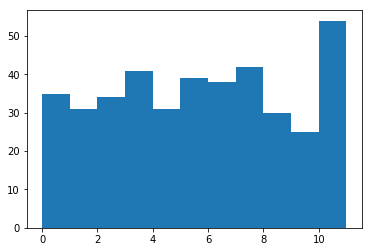

In [12]:
seed = 3
if do_pose_clf:
    n_classes = n_pose_classes
    in_labels = pose_labels
elif do_unsup_clf:    
    n_classes = 12
    unsup_clf = KMeans(n_clusters=n_classes, random_state=seed)
    in_labels = unsup_clf.fit_predict(gt_latent_params)
    plt.hist(in_labels, bins=np.arange(n_classes))
else:
    assert(False)

splits = prepare_train_test_val(n_shapes, in_labels, train_per, test_per, seed=seed)

In [23]:
from helper import load_meshes
from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [101]:
# c_id = 2
from general_tools.clustering.convenience import find_nearest_neighbors
c_id = 3
c = unsup_clf.cluster_centers_[c_id].reshape(1, 12)
ids = np.where(in_labels==c_id)[0]
p = gt_latent_params[ids]
ids2 = find_nearest_neighbors(c, p, k=5)[0][0]
ids = ids[ids2]
picked = load_meshes(ids + 1)

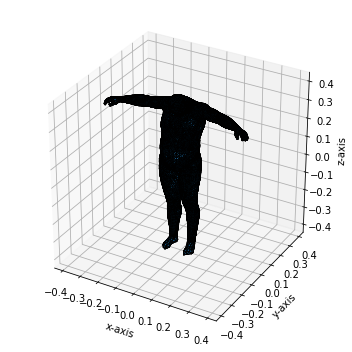

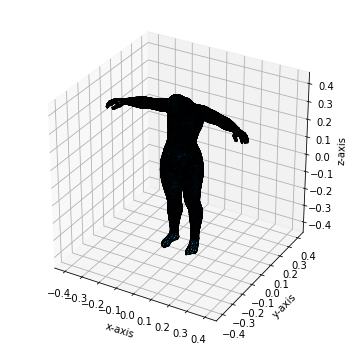

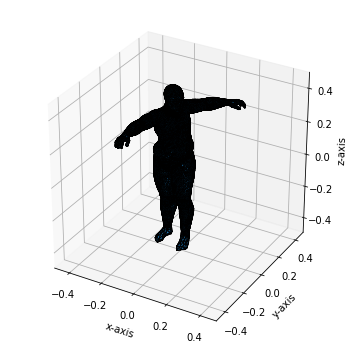

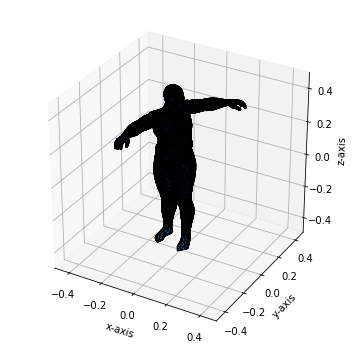

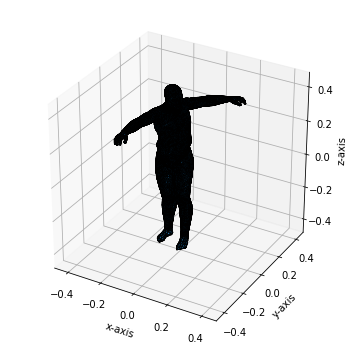

In [102]:
for i, in_m in enumerate(picked):
    f = plot_mesh(in_m)

In [64]:
use_pc = True
if use_pc:
    feeds = in_pcs
else:
    feeds = in_diffs

in_data = make_data(splits, feeds, in_labels)

['feed', 'labels', 'ids']
['feed', 'labels', 'ids']
['feed', 'labels', 'ids']


In [65]:
# VARIOUS ways to normalize the data
# in_diffs -= np.mean(in_diffs, axis=0)
train_data = in_data['train']
val_data = in_data['val']
test_data = in_data['test']
if not use_pc and mean_norm_diffs:
    diff_mu = np.mean(train_data.feed, axis=0)
    train_data.feed -= diff_mu    
#     diff_sigma = np.std(train_data.feed, axis=0)
#     train_data.feed /= diff_sigma
    test_data.feed -= diff_mu
#     test_data.feed /= diff_sigma
    val_data.feed -= diff_mu
#     val_data.feed /= diff_sigma    
#     test_data.feed -= np.mean(test_data.feed, axis=0)
#     val_data.feed -= np.mean(val_data.feed, axis=0)

In [66]:
arch = 'mlp'
reset_tf_graph()

if use_pc:
    feed_pl, labels_pl, logits = pc_net(n_pc_points)
else:
    in_shape = in_data['train'].feed[0].shape
    with tf.variable_scope('diff_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, ) + in_shape)
        labels_pl = tf.placeholder(tf.int64, shape=[None])
        if arch == 'mlp':
            layer = fully_connected(feed_pl, 100, activation='relu', weights_init='xavier')                    
        elif arch == 'conv':
            layer = tf.expand_dims(feed_pl, -1)
#             layer = feed_pl
            print layer
            layer = conv_2d(layer, nb_filter=64, filter_size=6, strides=3, activation='relu')
            print layer
            layer = conv_2d(layer, nb_filter=64, filter_size=2, strides=2, activation='relu')
            print layer
        else:
            assert(False)
    logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
print count_trainable_parameters()

76044


In [67]:
prediction = tf.argmax(logits, axis=1)
target_ = labels_pl
correct_pred = tf.equal(prediction, target_)
avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
one_hot_labels = tf.one_hot(labels_pl, depth=n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)

if use_pc:
    learning_rate = 0.005
    batch_size = 50
    n_epochs = 1000
else:
    learning_rate = 0.005
    batch_size = 50
    n_epochs = 1000

opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [68]:
train_losses = []
val_losses = []
test_losses = []
batches_for_epoch = train_data.n_examples / batch_size
train_res = defaultdict(list)

In [69]:
for epoch in range(n_epochs):
    is_training(True, session=sess)
    for _ in range(batches_for_epoch):        
        batch_d, batch_l, _ = train_data.next_batch(batch_size)
        feed_dict = {feed_pl:batch_d, labels_pl:batch_l}
        sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    is_training(False, session=sess)
    print epoch,
    
    for s in ['train', 'test', 'val']:
        feed_dict = {feed_pl:in_data[s].feed, labels_pl:in_data[s].labels}
        r = sess.run([avg_accuracy], feed_dict=feed_dict)
        train_res[s].append(r)
        print r,
    print

ResourceExhaustedError: OOM when allocating tensor with shape[50,2048,1,128]
	 [[Node: pc_based_net/encoder_conv_layer_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](pc_based_net/encoder_conv_layer_1/ExpandDims, pc_based_net/encoder_conv_layer_1/W/read)]]
	 [[Node: Mean_1/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_493_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'pc_based_net/encoder_conv_layer_1/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-059ff14722fb>", line 5, in <module>
    feed_pl, labels_pl, logits = pc_net(n_pc_points)
  File "<ipython-input-10-bd22831bd906>", line 20, in pc_net
    layer = encoder_with_convs_and_symmetry_new(feed_pl, n_filters=[64, 128, 256], b_norm=False)
  File "/orions4-zfs/projects/optas/Git_Repos/tf_lab/point_clouds/encoders_decoders.py", line 55, in encoder_with_convs_and_symmetry_new
    weight_decay=weight_decay, name=name, reuse=reuse, scope=scope_i, padding=padding)
  File "/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tflearn/layers/conv.py", line 840, in conv_1d
    inference = tf.nn.conv2d(inference, W, strides, padding)
  File "/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50,2048,1,128]
	 [[Node: pc_based_net/encoder_conv_layer_1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](pc_based_net/encoder_conv_layer_1/ExpandDims, pc_based_net/encoder_conv_layer_1/W/read)]]
	 [[Node: Mean_1/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_493_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


[ 0.73333341]
7


0.6851604

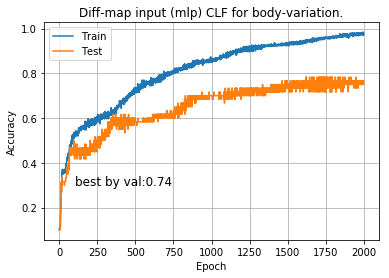

In [31]:
plt.plot(train_res['train'])
plt.plot(train_res['test'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

if use_pc:
    title_tag = 'Raw input'
else:
    title_tag = 'Diff-map input (%s)' % (arch,)

plt.title('%s CLF for body-variation.'% (title_tag, ))

val_maximizers = np.where(train_res['val'] == np.max(train_res['val']))[0]
val_best = np.mean(np.array(train_res['test'])[val_maximizers])
plt.text(100, 0.3, 'best by val:%.2f' % (val_best,), fontsize=12);

print np.array(train_res['test'])[val_maximizers[-1]]

print len(val_maximizers)
np.mean(np.array(train_res['test'])[int(n_epochs - n_epochs*0.05):])

In [59]:
from general_tools.clustering.plt import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [58]:
s = 'test'
l = in_data[s].labels

feed_dict = {feed_pl:in_data[s].feed, labels_pl:l}
p = sess.run([prediction], feed_dict=feed_dict)[0]

conf_m = confusion_matrix(l, p)

Confusion matrix, without normalization
[[2 0 0 0 1 0 0 1 1 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 1 0 0 0 0 0 0 0 0]
 [1 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 1 0 5 0 0 0 0 0 0]
 [0 0 1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 1 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0]
 [1 0 0 0 0 0 0 0 0 0 3 1]
 [0 0 0 0 0 0 0 0 0 1 0 3]]


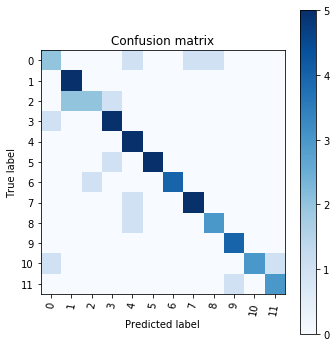

In [62]:
import inspect
inspect.getargspec(plot_confusion_matrix)
plot_confusion_matrix(conf_m, np.unique(in_labels))

In [65]:
in_class_p = 0.01
out_class_p = 0.01
p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
np.fill_diagonal(p_matrix, in_class_p)
adj = SBM_from_class_labels(sorted(in_labels), p_matrix)

500

In [48]:
import random
import numpy as np

def SBM_from_class_labels(vertex_labels, p_matrix):
    n_vertices = len(vertex_labels)
    adjacency = np.zeros(shape=(n_vertices, n_vertices), dtype=np.bool)
    for row, _row in enumerate(adjacency):
        for col, _col in enumerate(adjacency[row]):
            community_a = vertex_labels[row]
            community_b = vertex_labels[col]
            
            p = random.random()
            val = p_matrix[community_a][community_b]

            if p <= val:
                adjacency[row][col] = 1
                adjacency[col][row] = 1
    return adjacency

In [67]:
# feed_dict = {diffs_pl:test_data.diff_maps, labels_pl:test_data.labels}
# pred = sess.run(prediction, feed_dict=feed_dict)
# missed = np.where(test_data.labels != pred)
# pred[missed]
# test_data.labels[missed]
# test_data.ids[missed]

In [207]:
grid_scaler = np.arange(np.prod(diff_dims)).reshape(diff_dims)
loc_scaled_diffs = []
for d in in_diffs:
    loc_scaled_diffs.append(d + grid_scaler)

In [ ]:
# d = in_diffs[0]
# # plt.imshow(d)
# # d = np.hstack((d, np.zeros(50).reshape(-1, 1)))
# # print d.shape
# # # coeffs = pywt.dwt2(d, 'haar')
# # # print coeffs[0].shape
# # cc = (d[0:25,0:13], (d[0:25, 13:], d[25:, 0:13], d[25:,13:]))
# # lala = pywt.idwt2(cc, 'haar')
# # # plt.imshow(lala)
# # plt.imshow(lala)
# # plt.imshow(np.bmat([coeffs[0], coeffs[1][0]],[coeffs[1][1], coeffs[1][2]]))
# # plt.imshow(in_diffs[-1])
# # len(coeffs)
# # coeffs[1][2].shape

# import pywt

# haar_diffs = []
# for d in in_diffs:
# #     coeffs = pywt.dwt2(d, 'haar')
# #     haar_diffs.append(coeffs[0])

#     dd = np.hstack((d, np.zeros(50).reshape(-1, 1)))
#     cc = (dd[0:25,0:13], (dd[0:25, 13:], dd[25:, 0:13], dd[25:,13:]))
#     haar_diffs.append(pywt.idwt2(cc, 'haar'))

# #     coeffs = [d, (d, d, d)]
# #     haar_diffs.append(pywt.idwt2(coeffs, 'haar'))


# haar_diffs = np.array(haar_diffs)

In [ ]:


# for epoch in range(n_epochs):
#     for _ in range(batches_for_epoch):        
#         batch_d, batch_l, batch_dd = train_data.next_batch(batch_size)
#         feed_dict = {feed_pl_1:batch_d, labels_pl:batch_l, feed_pl_2:batch_dd}
#         sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    
#     print epoch,
#     for s in ['train', 'test', 'val']:
#         feed_dict = {feed_pl_1:in_data[s].feed, labels_pl:in_data[s].labels, feed_pl_2:in_data[s].ids}
#         r = sess.run([avg_accuracy], feed_dict=feed_dict)        
#         train_res[s].append(r)
#         print r,
#     print


# from tf_lab.data_sets.numpy_dataset import NumpyDataset
# def make_data_mixed(in_data, in_pc, class_labels, in_diff):
#     res = dict()
#     for s in ['train', 'test', 'val']:
#         idx = in_data[s].copy()        
#         res[s] = NumpyDataset([in_pc[idx], class_labels[idx], in_diff[idx]], ['feed', 'labels', 'ids'])
#     return res

# in_data = make_data_mixed(splits, in_pcs, in_labels, in_diffs)

In [ ]:
# is_directed = False
# n_shapes
# from geo_tool.utils.graph_generators import gnm_random_graph
# from geo_tool import Graph

# g = gnm_random_graph(n_shapes, n_shapes*4, directed=is_directed)
# print Graph.connected_components(g)[0]
# gg = Graph(g, is_directed)


# # splits['train']

# in_class_p = 0.01
# out_class_p = 0.05
# p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
# np.fill_diagonal(p_matrix, in_class_p)


# adj = SBM_from_class_labels(in_labels, p_matrix)

# for s in ['test', 'val']:
#     for idx in splits[s]:
#         adj[idx,:] = 0
#         adj[:,idx] = 0
        
# plt.imshow(g.toarray())
# plt.imshow(adj)

# mixed = np.array(g.toarray() + adj, dtype=bool)
# savemat('50_mixed_net.mat', {'W': mixed} )

In [ ]:
#     labels_pl = tf.placeholder(tf.int64, shape=[None])
#     diff_dims = (60, 30)
#     feed_pl_1 = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
#     feed_pl_2 = tf.placeholder(tf.float32, shape = (None, ) + diff_dims)
    
#     layer_pc = encoder_with_convs_and_symmetry_new(feed_pl_1, n_filters=[64, 128], b_norm=False)
    
    
#     layer = conv_2d(tf.expand_dims(feed_pl_2, -1), nb_filter=4, filter_size=4, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = conv_2d(layer, nb_filter=4, filter_size=3, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = fully_connected(layer, 6, activation='relu', weights_init='xavier')    
#     layer_diff = fully_connected(layer, 64, activation='relu', weights_init='xavier')
#     layer = tf.concat([layer_pc, layer_diff], axis=1)    
#     layer = fully_connected(layer, 32, activation='relu', weights_init='xavier')
#     logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    

In [164]:
def add_location_info_on_diffs(in_diffs, scaler=1.0):
    diff_dims = in_diffs.shape[1:]
    row_pos = np.repeat(np.arange(diff_dims[0]), diff_dims[1]).reshape(diff_dims)
    col_pos = np.repeat(np.arange(diff_dims[1]), diff_dims[0]).reshape(diff_dims[1], diff_dims[0]).T
    row_pos = row_pos.astype(np.float32)
    col_pos = col_pos.astype(np.float32)
    row_pos *= scaler
    col_pos *= scaler

    diffs_with_pos = np.zeros(shape=in_diffs.shape + (3,))
    for i, d in enumerate(in_diffs):
        diffs_with_pos[i, :, :, 0] = d
        diffs_with_pos[i, :, :, 1] = row_pos
        diffs_with_pos[i, :, :, 2] = col_pos
    return diffs_with_pos
